# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [1]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 8

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [5]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.5636, 0.4651, 0.4282,  ..., 0.4194, 0.3808, 0.4827],
         [0.6081, 0.5144, 0.4587,  ..., 0.4060, 0.3738, 0.4628],
         [0.6426, 0.5595, 0.5021,  ..., 0.3738, 0.3439, 0.4206],
         ...,
         [0.4733, 0.4728, 0.4640,  ..., 0.2917, 0.3040, 0.3081],
         [0.4774, 0.4728, 0.4657,  ..., 0.2935, 0.3046, 0.2982],
         [0.4815, 0.4833, 0.4815,  ..., 0.3017, 0.3093, 0.3005]],

        [[0.7091, 0.5759, 0.5193,  ..., 0.4792, 0.4392, 0.5653],
         [0.7636, 0.6370, 0.5598,  ..., 0.4637, 0.4316, 0.5493],
         [0.8102, 0.6930, 0.6119,  ..., 0.4231, 0.3971, 0.5003],
         ...,
         [0.5503, 0.5483, 0.5343,  ..., 0.3590, 0.3681, 0.3771],
         [0.5558, 0.5503, 0.5353,  ..., 0.3645, 0.3716, 0.3686],
         [0.5558, 0.5578, 0.5528,  ..., 0.3791, 0.3816, 0.3711]],

        [[0.8345, 0.6781, 0.6002,  ..., 0.5345, 0.4936, 0.6053],
         [0.8896, 0.7437, 0.6473,  ..., 0.5176, 0.4854, 0.5941],
         [0.9367, 0.8033, 0.7075,  ..., 0.4756, 0.4455, 0.

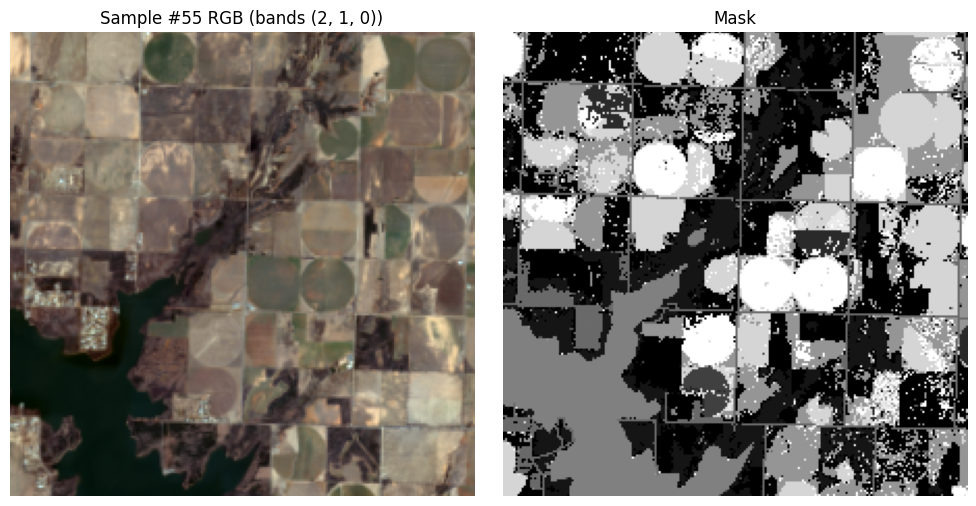

tensor([[[0.1655, 0.1671, 0.1662,  ..., 0.1089, 0.1157, 0.1146],
         [0.1547, 0.1529, 0.1429,  ..., 0.1481, 0.1183, 0.1048],
         [0.1335, 0.1313, 0.1242,  ..., 0.1148, 0.1098, 0.1030],
         ...,
         [0.1699, 0.1520, 0.1411,  ..., 0.1814, 0.1660, 0.1703],
         [0.1640, 0.1688, 0.1671,  ..., 0.1904, 0.1760, 0.1682],
         [0.1451, 0.1492, 0.1479,  ..., 0.1926, 0.1856, 0.1723]],

        [[0.1610, 0.1621, 0.1621,  ..., 0.1312, 0.1331, 0.1250],
         [0.1546, 0.1532, 0.1474,  ..., 0.1583, 0.1306, 0.1189],
         [0.1372, 0.1389, 0.1391,  ..., 0.1246, 0.1162, 0.1112],
         ...,
         [0.1976, 0.1755, 0.1606,  ..., 0.2112, 0.1937, 0.1990],
         [0.1908, 0.1964, 0.1947,  ..., 0.2243, 0.2055, 0.1945],
         [0.1691, 0.1749, 0.1751,  ..., 0.2298, 0.2179, 0.1999]],

        [[0.1913, 0.1941, 0.1938,  ..., 0.1517, 0.1620, 0.1620],
         [0.1872, 0.1866, 0.1781,  ..., 0.2050, 0.1811, 0.1713],
         [0.1711, 0.1791, 0.1790,  ..., 0.1743, 0.1602, 0.

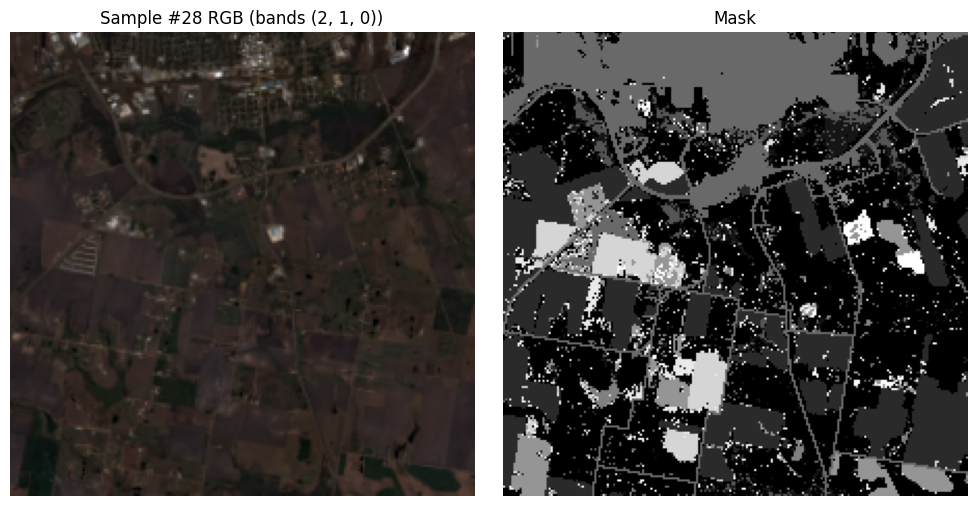

In [6]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [7]:
model = UnetPlusPlus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

dice_loss = DiceLoss(mode="multiclass", from_logits=True)
focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    # DiceLoss will internally one-hot `targets`
    L_dice  = dice_loss(preds, targets)
    # FocalLoss expects integer class labels
    L_focal = focal_loss(preds, targets)
    L_ce = ce_loss(preds, targets)

    return 1 * L_ce


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-7-1b0310b2e68a>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [8]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/309 [00:00<?, ?it/s]<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 309/309 [11:29<00:00,  2.23s/it]


[Epoch  0] Loss:  2.1097, Acc:   0.1489, IoU:   0.0825, Dice:  0.0768, mIoU:  0.0543


Epoch 1/50 [Val]: 100%|██████████| 78/78 [01:51<00:00,  1.42s/it]


[Epoch  0] Loss: 1.8400, Acc: 0.2792, IoU: 0.1622, Dice: 0.1336, mIoU: 0.0978


Epoch 2/50: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch  1] Loss:  1.7817, Acc:   0.2837, IoU:   0.1740, Dice:  0.1444, mIoU:  0.1076


Epoch 2/50 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.02s/it]


[Epoch  1] Loss: 1.7070, Acc: 0.3062, IoU: 0.1909, Dice: 0.1544, mIoU: 0.1172


Epoch 3/50: 100%|██████████| 309/309 [06:43<00:00,  1.31s/it]


[Epoch  2] Loss:  1.6656, Acc:   0.3330, IoU:   0.2160, Dice:  0.1734, mIoU:  0.1314


Epoch 3/50 [Val]: 100%|██████████| 78/78 [01:22<00:00,  1.05s/it]


[Epoch  2] Loss: 1.6195, Acc: 0.3727, IoU: 0.2447, Dice: 0.1926, mIoU: 0.1474


Epoch 4/50: 100%|██████████| 309/309 [06:39<00:00,  1.29s/it]


[Epoch  3] Loss:  1.5876, Acc:   0.3745, IoU:   0.2504, Dice:  0.1962, mIoU:  0.1511


Epoch 4/50 [Val]: 100%|██████████| 78/78 [01:21<00:00,  1.05s/it]


[Epoch  3] Loss: 1.6769, Acc: 0.3401, IoU: 0.2262, Dice: 0.1747, mIoU: 0.1343


Epoch 5/50: 100%|██████████| 309/309 [06:32<00:00,  1.27s/it]


[Epoch  4] Loss:  1.5339, Acc:   0.3977, IoU:   0.2699, Dice:  0.2105, mIoU:  0.1639


Epoch 5/50 [Val]: 100%|██████████| 78/78 [01:21<00:00,  1.04s/it]


[Epoch  4] Loss: 1.5542, Acc: 0.3964, IoU: 0.2748, Dice: 0.2127, mIoU: 0.1654


Epoch 6/50: 100%|██████████| 309/309 [06:25<00:00,  1.25s/it]


[Epoch  5] Loss:  1.4857, Acc:   0.4189, IoU:   0.2881, Dice:  0.2223, mIoU:  0.1748


Epoch 6/50 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.17s/it]


[Epoch  5] Loss: 1.4783, Acc: 0.4334, IoU: 0.2930, Dice: 0.2235, mIoU: 0.1761


Epoch 7/50: 100%|██████████| 309/309 [06:27<00:00,  1.25s/it]


[Epoch  6] Loss:  1.4613, Acc:   0.4276, IoU:   0.2954, Dice:  0.2280, mIoU:  0.1802


Epoch 7/50 [Val]: 100%|██████████| 78/78 [01:18<00:00,  1.01s/it]


[Epoch  6] Loss: 1.4762, Acc: 0.4206, IoU: 0.2960, Dice: 0.2222, mIoU: 0.1754


Epoch 8/50: 100%|██████████| 309/309 [06:34<00:00,  1.28s/it]


[Epoch  7] Loss:  1.4265, Acc:   0.4396, IoU:   0.3071, Dice:  0.2348, mIoU:  0.1875


Epoch 8/50 [Val]: 100%|██████████| 78/78 [01:22<00:00,  1.05s/it]


[Epoch  7] Loss: 1.4468, Acc: 0.4089, IoU: 0.2891, Dice: 0.2273, mIoU: 0.1825


Epoch 9/50: 100%|██████████| 309/309 [06:19<00:00,  1.23s/it]


[Epoch  8] Loss:  1.3923, Acc:   0.4537, IoU:   0.3195, Dice:  0.2407, mIoU:  0.1935


Epoch 9/50 [Val]: 100%|██████████| 78/78 [01:21<00:00,  1.04s/it]


[Epoch  8] Loss: 1.4170, Acc: 0.4462, IoU: 0.3160, Dice: 0.2321, mIoU: 0.1878


Epoch 10/50: 100%|██████████| 309/309 [06:33<00:00,  1.27s/it]


[Epoch  9] Loss:  1.3750, Acc:   0.4608, IoU:   0.3257, Dice:  0.2448, mIoU:  0.1984


Epoch 10/50 [Val]: 100%|██████████| 78/78 [01:20<00:00,  1.04s/it]


[Epoch  9] Loss: 1.3958, Acc: 0.4491, IoU: 0.3167, Dice: 0.2345, mIoU: 0.1906


Epoch 11/50: 100%|██████████| 309/309 [06:17<00:00,  1.22s/it]


[Epoch 10] Loss:  1.3538, Acc:   0.4696, IoU:   0.3336, Dice:  0.2485, mIoU:  0.2028


Epoch 11/50 [Val]: 100%|██████████| 78/78 [01:30<00:00,  1.16s/it]


[Epoch 10] Loss: 1.4352, Acc: 0.4476, IoU: 0.3113, Dice: 0.2297, mIoU: 0.1891


Epoch 12/50: 100%|██████████| 309/309 [06:16<00:00,  1.22s/it]


[Epoch 11] Loss:  1.3299, Acc:   0.4786, IoU:   0.3413, Dice:  0.2528, mIoU:  0.2079


Epoch 12/50 [Val]: 100%|██████████| 78/78 [01:17<00:00,  1.01it/s]


[Epoch 11] Loss: 1.3732, Acc: 0.4607, IoU: 0.3225, Dice: 0.2436, mIoU: 0.2037


Epoch 13/50: 100%|██████████| 309/309 [06:19<00:00,  1.23s/it]


[Epoch 12] Loss:  1.3048, Acc:   0.4889, IoU:   0.3504, Dice:  0.2570, mIoU:  0.2135


Epoch 13/50 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.03s/it]


[Epoch 12] Loss: 1.3910, Acc: 0.4765, IoU: 0.3228, Dice: 0.2387, mIoU: 0.1969


Epoch 14/50: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch 13] Loss:  1.2941, Acc:   0.4933, IoU:   0.3540, Dice:  0.2591, mIoU:  0.2162


Epoch 14/50 [Val]: 100%|██████████| 78/78 [01:30<00:00,  1.16s/it]


[Epoch 13] Loss: 1.3278, Acc: 0.4815, IoU: 0.3446, Dice: 0.2483, mIoU: 0.2067


Epoch 15/50: 100%|██████████| 309/309 [06:09<00:00,  1.20s/it]


[Epoch 14] Loss:  1.2832, Acc:   0.4990, IoU:   0.3592, Dice:  0.2619, mIoU:  0.2193


Epoch 15/50 [Val]: 100%|██████████| 78/78 [01:24<00:00,  1.08s/it]


[Epoch 14] Loss: 1.3056, Acc: 0.4931, IoU: 0.3518, Dice: 0.2621, mIoU: 0.2212


Epoch 16/50: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch 15] Loss:  1.2656, Acc:   0.5049, IoU:   0.3642, Dice:  0.2645, mIoU:  0.2229


Epoch 16/50 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.19s/it]


[Epoch 15] Loss: 1.3575, Acc: 0.4996, IoU: 0.3422, Dice: 0.2481, mIoU: 0.2021


Epoch 17/50: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch 16] Loss:  1.2488, Acc:   0.5123, IoU:   0.3711, Dice:  0.2684, mIoU:  0.2271


Epoch 17/50 [Val]: 100%|██████████| 78/78 [01:22<00:00,  1.06s/it]


[Epoch 16] Loss: 1.2903, Acc: 0.4968, IoU: 0.3572, Dice: 0.2602, mIoU: 0.2179


Epoch 18/50: 100%|██████████| 309/309 [06:15<00:00,  1.22s/it]


[Epoch 17] Loss:  1.2382, Acc:   0.5167, IoU:   0.3748, Dice:  0.2705, mIoU:  0.2300


Epoch 18/50 [Val]: 100%|██████████| 78/78 [01:30<00:00,  1.16s/it]


[Epoch 17] Loss: 1.3062, Acc: 0.4893, IoU: 0.3564, Dice: 0.2572, mIoU: 0.2170


Epoch 19/50: 100%|██████████| 309/309 [06:03<00:00,  1.18s/it]


[Epoch 18] Loss:  1.2187, Acc:   0.5233, IoU:   0.3808, Dice:  0.2740, mIoU:  0.2337


Epoch 19/50 [Val]: 100%|██████████| 78/78 [01:23<00:00,  1.07s/it]


[Epoch 18] Loss: 1.3029, Acc: 0.4986, IoU: 0.3568, Dice: 0.2491, mIoU: 0.2109


Epoch 20/50: 100%|██████████| 309/309 [06:22<00:00,  1.24s/it]


[Epoch 19] Loss:  1.2075, Acc:   0.5292, IoU:   0.3855, Dice:  0.2764, mIoU:  0.2366


Epoch 20/50 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 19] Loss: 1.2856, Acc: 0.4903, IoU: 0.3568, Dice: 0.2646, mIoU: 0.2272


Epoch 21/50: 100%|██████████| 309/309 [06:22<00:00,  1.24s/it]


[Epoch 20] Loss:  1.2036, Acc:   0.5301, IoU:   0.3869, Dice:  0.2778, mIoU:  0.2383


Epoch 21/50 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.17s/it]


[Epoch 20] Loss: 1.2588, Acc: 0.5285, IoU: 0.3739, Dice: 0.2646, mIoU: 0.2251


Epoch 22/50: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch 21] Loss:  1.1995, Acc:   0.5336, IoU:   0.3897, Dice:  0.2787, mIoU:  0.2394


Epoch 22/50 [Val]: 100%|██████████| 78/78 [01:26<00:00,  1.11s/it]


[Epoch 21] Loss: 1.2514, Acc: 0.5109, IoU: 0.3703, Dice: 0.2659, mIoU: 0.2278


Epoch 23/50: 100%|██████████| 309/309 [06:14<00:00,  1.21s/it]


[Epoch 22] Loss:  1.1778, Acc:   0.5392, IoU:   0.3949, Dice:  0.2815, mIoU:  0.2430


Epoch 23/50 [Val]: 100%|██████████| 78/78 [01:08<00:00,  1.14it/s]


[Epoch 22] Loss: 1.2297, Acc: 0.5296, IoU: 0.3811, Dice: 0.2789, mIoU: 0.2395


Epoch 24/50: 100%|██████████| 309/309 [06:13<00:00,  1.21s/it]


[Epoch 23] Loss:  1.1735, Acc:   0.5424, IoU:   0.3979, Dice:  0.2840, mIoU:  0.2455


Epoch 24/50 [Val]: 100%|██████████| 78/78 [01:29<00:00,  1.15s/it]


[Epoch 23] Loss: 1.2374, Acc: 0.5243, IoU: 0.3758, Dice: 0.2751, mIoU: 0.2352


Epoch 25/50: 100%|██████████| 309/309 [06:13<00:00,  1.21s/it]


[Epoch 24] Loss:  1.1670, Acc:   0.5464, IoU:   0.4014, Dice:  0.2854, mIoU:  0.2472


Epoch 25/50 [Val]: 100%|██████████| 78/78 [01:05<00:00,  1.18it/s]


[Epoch 24] Loss: 1.2184, Acc: 0.5041, IoU: 0.3730, Dice: 0.2687, mIoU: 0.2352


Epoch 26/50: 100%|██████████| 309/309 [06:50<00:00,  1.33s/it]


[Epoch 25] Loss:  1.1577, Acc:   0.5478, IoU:   0.4032, Dice:  0.2874, mIoU:  0.2498


Epoch 26/50 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


[Epoch 25] Loss: 1.1886, Acc: 0.5311, IoU: 0.3950, Dice: 0.2797, mIoU: 0.2444


Epoch 27/50: 100%|██████████| 309/309 [06:19<00:00,  1.23s/it]


[Epoch 26] Loss:  1.1480, Acc:   0.5514, IoU:   0.4065, Dice:  0.2888, mIoU:  0.2511


Epoch 27/50 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch 26] Loss: 1.2171, Acc: 0.5302, IoU: 0.3856, Dice: 0.2727, mIoU: 0.2356


Epoch 28/50: 100%|██████████| 309/309 [06:20<00:00,  1.23s/it]


[Epoch 27] Loss:  1.1365, Acc:   0.5571, IoU:   0.4111, Dice:  0.2912, mIoU:  0.2539


Epoch 28/50 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 27] Loss: 1.2226, Acc: 0.5202, IoU: 0.3811, Dice: 0.2793, mIoU: 0.2429


Epoch 29/50: 100%|██████████| 309/309 [06:23<00:00,  1.24s/it]


[Epoch 28] Loss:  1.1291, Acc:   0.5613, IoU:   0.4153, Dice:  0.2934, mIoU:  0.2568


Epoch 29/50 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.19s/it]


[Epoch 28] Loss: 1.2758, Acc: 0.4930, IoU: 0.3623, Dice: 0.2668, mIoU: 0.2321


Epoch 30/50: 100%|██████████| 309/309 [06:26<00:00,  1.25s/it]


[Epoch 29] Loss:  1.1315, Acc:   0.5609, IoU:   0.4148, Dice:  0.2930, mIoU:  0.2560


Epoch 30/50 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.16it/s]


[Epoch 29] Loss: 1.2132, Acc: 0.5351, IoU: 0.3855, Dice: 0.2775, mIoU: 0.2382


Epoch 31/50: 100%|██████████| 309/309 [06:30<00:00,  1.26s/it]


[Epoch 30] Loss:  1.1239, Acc:   0.5628, IoU:   0.4166, Dice:  0.2948, mIoU:  0.2584


Epoch 31/50 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


[Epoch 30] Loss: 1.1833, Acc: 0.5478, IoU: 0.3961, Dice: 0.2878, mIoU: 0.2517


Epoch 32/50: 100%|██████████| 309/309 [06:28<00:00,  1.26s/it]


[Epoch 31] Loss:  1.1060, Acc:   0.5685, IoU:   0.4224, Dice:  0.2976, mIoU:  0.2615


Epoch 32/50 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 31] Loss: 1.1874, Acc: 0.5447, IoU: 0.3952, Dice: 0.2860, mIoU: 0.2486


Epoch 33/50: 100%|██████████| 309/309 [06:29<00:00,  1.26s/it]


[Epoch 32] Loss:  1.1034, Acc:   0.5702, IoU:   0.4231, Dice:  0.2978, mIoU:  0.2622


Epoch 33/50 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 32] Loss: 1.2444, Acc: 0.5170, IoU: 0.3823, Dice: 0.2775, mIoU: 0.2416


Epoch 34/50: 100%|██████████| 309/309 [06:32<00:00,  1.27s/it]


[Epoch 33] Loss:  1.1072, Acc:   0.5698, IoU:   0.4229, Dice:  0.2978, mIoU:  0.2623


Epoch 34/50 [Val]: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


[Epoch 33] Loss: 1.1823, Acc: 0.5419, IoU: 0.4000, Dice: 0.2864, mIoU: 0.2521


Epoch 35/50: 100%|██████████| 309/309 [06:34<00:00,  1.28s/it]


[Epoch 34] Loss:  1.0930, Acc:   0.5753, IoU:   0.4282, Dice:  0.3003, mIoU:  0.2651


Epoch 35/50 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 34] Loss: 1.1535, Acc: 0.5547, IoU: 0.4085, Dice: 0.2909, mIoU: 0.2562


Epoch 36/50: 100%|██████████| 309/309 [06:32<00:00,  1.27s/it]


[Epoch 35] Loss:  1.0856, Acc:   0.5785, IoU:   0.4312, Dice:  0.3018, mIoU:  0.2666


Epoch 36/50 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch 35] Loss: 1.1792, Acc: 0.5356, IoU: 0.3963, Dice: 0.2848, mIoU: 0.2489


Epoch 37/50: 100%|██████████| 309/309 [06:28<00:00,  1.26s/it]


[Epoch 36] Loss:  1.0799, Acc:   0.5811, IoU:   0.4336, Dice:  0.3036, mIoU:  0.2690


Epoch 37/50 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch 36] Loss: 1.2253, Acc: 0.5364, IoU: 0.3845, Dice: 0.2826, mIoU: 0.2446


Epoch 38/50: 100%|██████████| 309/309 [06:28<00:00,  1.26s/it]


[Epoch 37] Loss:  1.0782, Acc:   0.5801, IoU:   0.4334, Dice:  0.3038, mIoU:  0.2692


Epoch 38/50 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 37] Loss: 1.1614, Acc: 0.5427, IoU: 0.4051, Dice: 0.2893, mIoU: 0.2562


Epoch 39/50: 100%|██████████| 309/309 [06:27<00:00,  1.26s/it]


[Epoch 38] Loss:  1.0723, Acc:   0.5817, IoU:   0.4344, Dice:  0.3048, mIoU:  0.2706


Epoch 39/50 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.02s/it]


[Epoch 38] Loss: 1.2097, Acc: 0.5192, IoU: 0.3810, Dice: 0.2847, mIoU: 0.2495


Epoch 40/50: 100%|██████████| 309/309 [06:48<00:00,  1.32s/it]


[Epoch 39] Loss:  1.0603, Acc:   0.5877, IoU:   0.4402, Dice:  0.3073, mIoU:  0.2733


Epoch 40/50 [Val]: 100%|██████████| 78/78 [01:08<00:00,  1.14it/s]


[Epoch 39] Loss: 1.1690, Acc: 0.5429, IoU: 0.4016, Dice: 0.2884, mIoU: 0.2542


Epoch 41/50: 100%|██████████| 309/309 [07:04<00:00,  1.37s/it]


[Epoch 40] Loss:  1.0497, Acc:   0.5926, IoU:   0.4447, Dice:  0.3093, mIoU:  0.2758


Epoch 41/50 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.15it/s]


[Epoch 40] Loss: 1.1843, Acc: 0.5556, IoU: 0.3979, Dice: 0.2825, mIoU: 0.2479


Epoch 42/50: 100%|██████████| 309/309 [06:34<00:00,  1.28s/it]


[Epoch 41] Loss:  1.0186, Acc:   0.6063, IoU:   0.4579, Dice:  0.3153, mIoU:  0.2828


Epoch 42/50 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.26s/it]


[Epoch 41] Loss: 1.1067, Acc: 0.5740, IoU: 0.4239, Dice: 0.3002, mIoU: 0.2674


Epoch 43/50: 100%|██████████| 309/309 [06:47<00:00,  1.32s/it]


[Epoch 42] Loss:  1.0087, Acc:   0.6093, IoU:   0.4614, Dice:  0.3175, mIoU:  0.2854


Epoch 43/50 [Val]: 100%|██████████| 78/78 [01:22<00:00,  1.06s/it]


[Epoch 42] Loss: 1.1103, Acc: 0.5778, IoU: 0.4267, Dice: 0.3012, mIoU: 0.2685


Epoch 44/50: 100%|██████████| 309/309 [06:35<00:00,  1.28s/it]


[Epoch 43] Loss:  1.0080, Acc:   0.6104, IoU:   0.4623, Dice:  0.3180, mIoU:  0.2861


Epoch 44/50 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.24s/it]


[Epoch 43] Loss: 1.1146, Acc: 0.5693, IoU: 0.4230, Dice: 0.2996, mIoU: 0.2655


Epoch 45/50: 100%|██████████| 309/309 [06:38<00:00,  1.29s/it]


[Epoch 44] Loss:  1.0000, Acc:   0.6139, IoU:   0.4657, Dice:  0.3198, mIoU:  0.2880


Epoch 45/50 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 44] Loss: 1.1199, Acc: 0.5573, IoU: 0.4195, Dice: 0.2988, mIoU: 0.2670


Epoch 46/50: 100%|██████████| 309/309 [06:33<00:00,  1.28s/it]


[Epoch 45] Loss:  0.9953, Acc:   0.6153, IoU:   0.4672, Dice:  0.3198, mIoU:  0.2884


Epoch 46/50 [Val]: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


[Epoch 45] Loss: 1.1037, Acc: 0.5712, IoU: 0.4258, Dice: 0.3016, mIoU: 0.2688


Epoch 47/50: 100%|██████████| 309/309 [06:37<00:00,  1.29s/it]


[Epoch 46] Loss:  0.9955, Acc:   0.6161, IoU:   0.4677, Dice:  0.3209, mIoU:  0.2896


Epoch 47/50 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 46] Loss: 1.1205, Acc: 0.5616, IoU: 0.4226, Dice: 0.3017, mIoU: 0.2695


Epoch 48/50: 100%|██████████| 309/309 [06:32<00:00,  1.27s/it]


[Epoch 47] Loss:  0.9886, Acc:   0.6183, IoU:   0.4701, Dice:  0.3219, mIoU:  0.2907


Epoch 48/50 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.24s/it]


[Epoch 47] Loss: 1.1099, Acc: 0.5661, IoU: 0.4221, Dice: 0.3045, mIoU: 0.2720


Epoch 49/50: 100%|██████████| 309/309 [06:39<00:00,  1.29s/it]


[Epoch 48] Loss:  0.9872, Acc:   0.6188, IoU:   0.4709, Dice:  0.3226, mIoU:  0.2911


Epoch 49/50 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.27s/it]


[Epoch 48] Loss: 1.1283, Acc: 0.5693, IoU: 0.4213, Dice: 0.3001, mIoU: 0.2666


Epoch 50/50: 100%|██████████| 309/309 [06:38<00:00,  1.29s/it]


[Epoch 49] Loss:  0.9796, Acc:   0.6237, IoU:   0.4753, Dice:  0.3240, mIoU:  0.2933


Epoch 50/50 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


[Epoch 49] Loss: 1.1124, Acc: 0.5677, IoU: 0.4244, Dice: 0.3033, mIoU: 0.2716


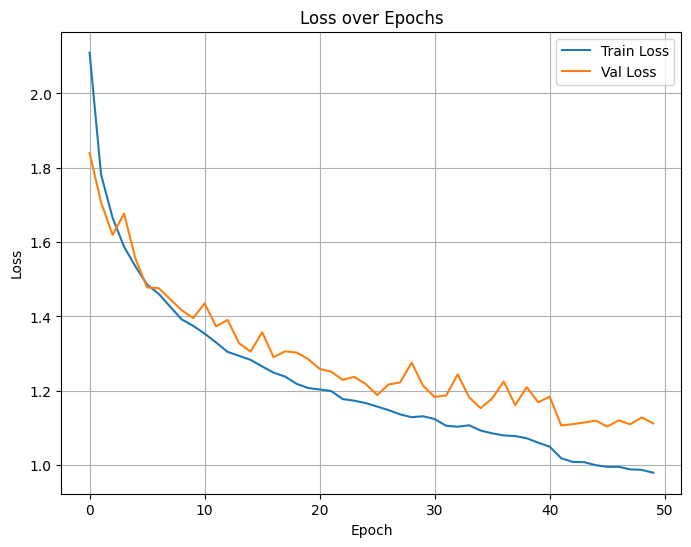

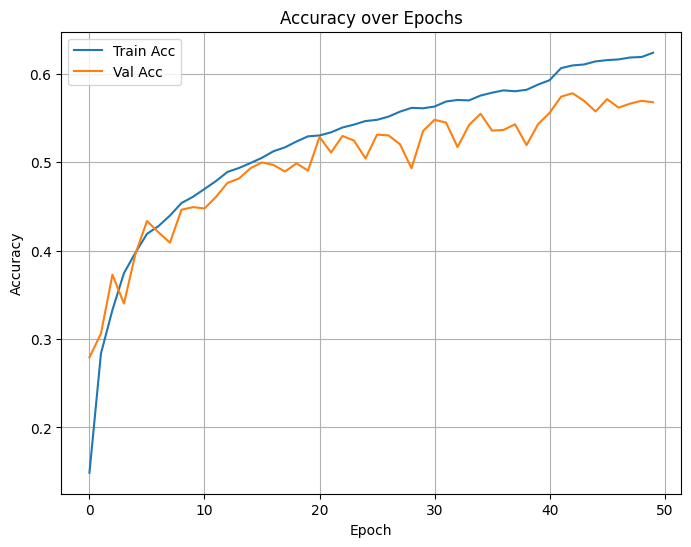

In [9]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(accuracy.compute().item())
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_8bs_50ep_lr1e-04_loss_20250520-015125_normalized_ce.png


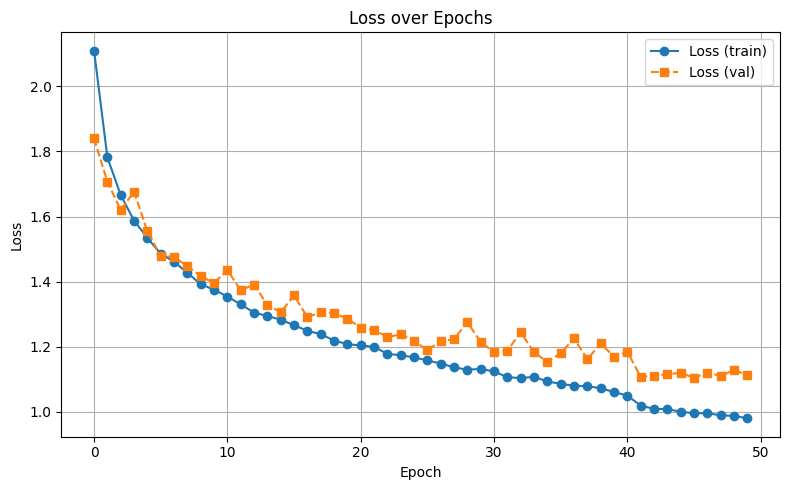

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_8bs_50ep_lr1e-04_accuracy_20250520-015125_normalized_ce.png


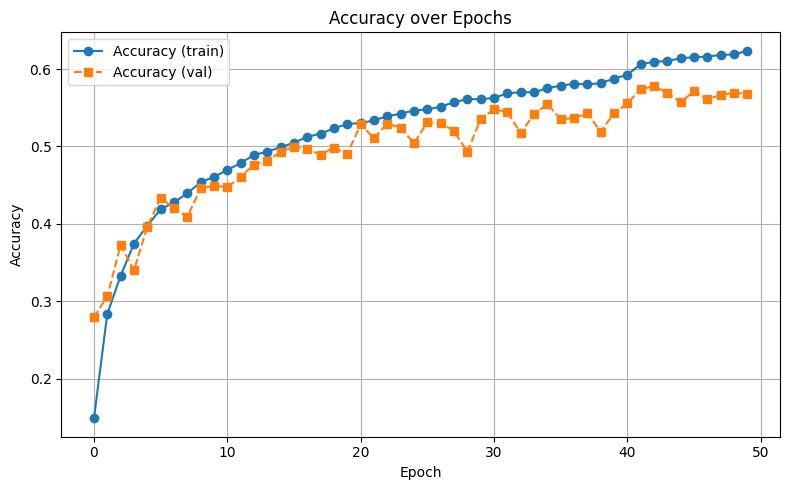

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_8bs_50ep_lr1e-04_iou_20250520-015125_normalized_ce.png


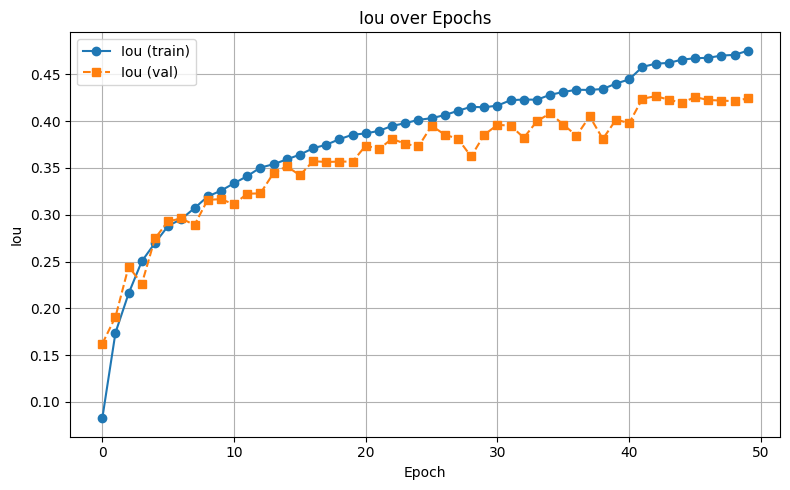

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_8bs_50ep_lr1e-04_dice_20250520-015125_normalized_ce.png


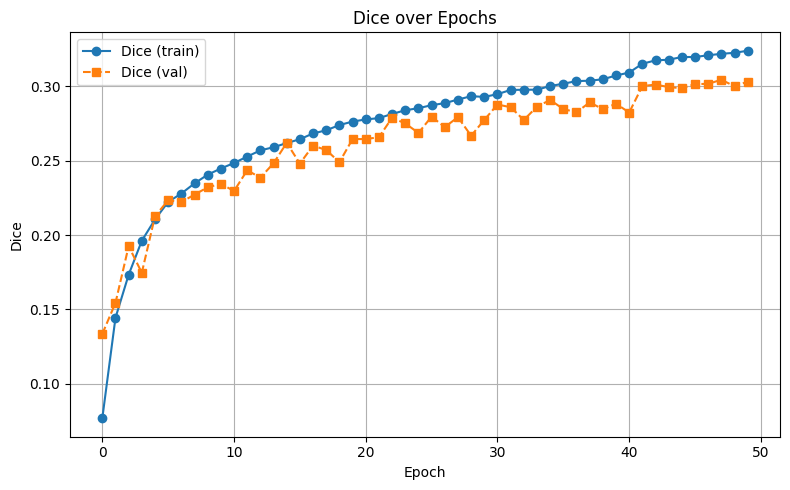

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_8bs_50ep_lr1e-04_miou_20250520-015125_normalized_ce.png


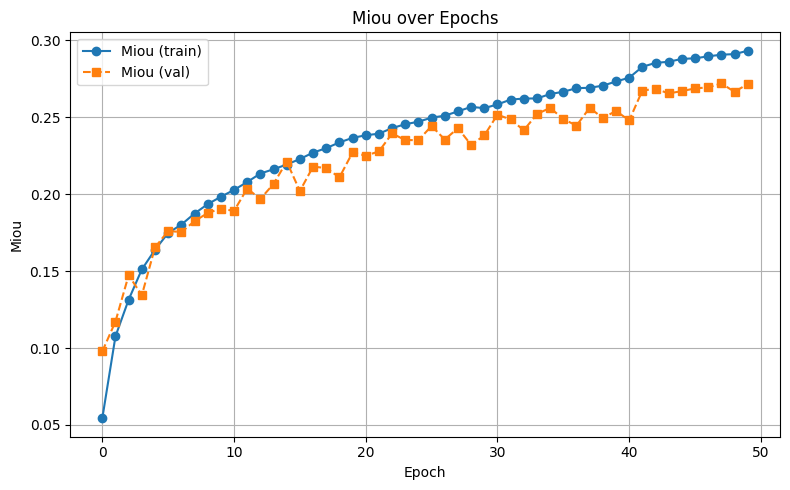

In [10]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_ce.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [11]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_ce.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/unet++_resnet34_None_8bs_50ep_lr1e-04_normalized_ce.pth


In [12]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_ce_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/unet++_resnet34_None_8bs_50ep_lr1e-04_normalized_ce_metrics.csv
